<a href="https://colab.research.google.com/github/andersjes/Deep-Learning/blob/main/Lab7_LearningRate_Regularization_HyperparameterSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 7: Training neural networks (part 2)
**Like always, remember to set Runtime environment to GPU**

In this lab we will explore more tools that will help you train your own neural networks. This time we will be using convolutional neural networks (CNNs).


##1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 46457133.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


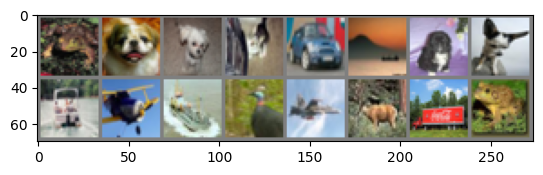

 frog   dog   dog   cat   car  ship   dog   dog  ship plane  ship  bird plane  deer truck  frog


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 2. Task 1 (optional): Setting up your CNN
**You can skip this task and jump directly to Task 2, if you feel comfortable with PyTorch and the different layer types used in CNNs.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear])

as well as the reshape operation (called `view` in PyTorch):

- [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view)

See complete overview of the basic building block for graphs [here](https://pytorch.org/docs/stable/nn.html).

Let's see how each of these work:

In [3]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

**Side-note:** What's the difference between torch.nn and torch.nn.functional? Read [here](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/7)

###2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [4]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


####2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?
2. Recall the formula to calculate the output size of a convolution:

 `output_size = (input_size - kernel_size) / stride + 1`

 or as defined in the slides of Lecture 4:

 `output_size = (N - W) / stride + 1`

 Is this formula satisfied in the above example?
3. How could you make the output (x) have the same width and height as the input (images)? (Think "padding"...)
4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

###2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [5]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[-1.5355,  0.9503, -0.3417,  1.7584],
        [-0.6022,  0.0341, -0.4120,  0.2268],
        [ 0.1473,  0.4956, -0.3521, -0.0520],
        [-1.1928, -0.3222, -0.9633,  0.6373]])
y[0,0,0:2,0:2]:
 tensor([[0.9503, 1.7584],
        [0.4956, 0.6373]])


####2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)
2. What do each of the parameters (2, 2) mean?

###2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

In [6]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(2.0084)
x.std tensor(10.0099)
y.mean tensor(4.8910e-09, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward0>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


####2.3.1 Questions
1. What does BacthNorm2D do?

sets the mean to 0 and std to 1.
2. What does the input parameter (6) mean?

expect a input of 6 channels.
3. Is the mean and standard deviation after batch normalization as expected?


4. How many parameters does BatchNorm2D have? Why?

gamma and beta are learnable. these are scaling and shifting the normalized values

running mean and runnnig variance. Nor learnable. these track the statistics of date.

###2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [7]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-4.3771)
x.max tensor(4.8889)
x[0,0,0:4,0:4]:
 tensor([[-0.6621, -0.1524,  0.6361,  1.2862],
        [ 1.1620, -0.6469, -1.2577, -0.6920],
        [ 1.0855, -1.9411,  0.2528, -1.3969],
        [-0.2350,  0.8634, -1.5263, -0.1719]])
y.min tensor(0.)
y.max tensor(4.8889)
y[0,0,0:4,0:4]:
 tensor([[0.0000, 0.0000, 0.6361, 1.2862],
        [1.1620, 0.0000, 0.0000, 0.0000],
        [1.0855, 0.0000, 0.2528, 0.0000],
        [0.0000, 0.8634, 0.0000, 0.0000]])


####2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)

every negative value becomes 0.

###2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view

Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).
2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [8]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

N = 6*28*28 # Solution

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

####2.5.1 Helper questions
1. What does `view` do?
faltten into a vector. or just reshape a tensor.

2. What does `Linear` do?

inplements linear transformation. the arguments are in_features and out_features.



##2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer:

In [13]:
# Random input - dimensions are (batch_size, num_in_features)
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.75)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([ 0.0841, -0.4620, -1.2396, -0.3130, -0.8040, -0.9046, -0.0242,  1.9090,
        -0.0678,  0.7734])
y[0,:] tensor([0.3363, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
        0.0000])
ratios tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

####2.6.1 Questions
1. Explain why there are zeroes in `y`.

these has been droped out to avoid overfitting.
2. Ratios: Why are the values of the non-zero entries of `y` twice as large as the corresponding values of the input `x`?

outputs are scaled.
3. What happens to the ratios if you set `p=0.75`?

neurons has a 75% of being droped outed. And the output is scaled even more.

##2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=???)
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=???, out_features=120)
        self.fc2 = nn.Linear(in_features=???, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, ???)
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Example code to find shape of input to first fully connected layer:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=16) # num_features = 16 because conv2 has out_channels = 16
        self.drop = nn.Dropout(p=0.5)
        #self.fc1 = nn.Linear(in_features=???, out_features=120) # in_features = 16*5*5 because output shape of previous layer is 16x5x5 (see code below)
        #self.fc2 = nn.Linear(in_features=???, out_features=10) # in_features = 120 becuase out_features of previous layer is 120

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        #x = x.view(-1, ???)
        #x = self.drop(x)
        #x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)
        return x

model = Net()

# Test model
x = model(images)
print(x.shape)

##3. Task 2: Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [ ]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

###3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 1. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The self-made Lambda layer helps us reshape the output of the last conv layer to a vector, because PyTorch has no built-in reshape layer. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Here is a useful function that you can call to re-initialize the weights/parameters of the model:

In [ ]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1? Gamma = scaling = 1
            torch.nn.init.constant_(m.bias, 0) # Why 0? Beta = offset = 0
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

###3.2 Testing the model
Let's test the model:

In [ ]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = Net().cuda()
scores = model(images)  # predictions

print(scores.shape)

###3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [ ]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

###3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [ ]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

###3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [ ]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    print(valid_loss_history)
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

###3.6 Train the model
Train the model and inspect the loss curves.

In [ ]:
# Re-initialize weights
reset_parameters(model)

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** The validation loss (on the unseen data) is overall *lower* than the training loss. This might initially seem like an unexpected behaviour, but it results from the fact that we use 50% Dropout during training, meaning that half of the weights of the fully connected layers are not used during training. When evaluating the model on the validation set, Dropout is disabled, and all weights are used. This leads to a better prediction (i.e., a lower loss) on the validation set.

###3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51,200`).


In [ ]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

In [ ]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

##4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform as good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD))

General recommendations for hyperparameter search (see Lecture 6 slides):
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


###4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

**Solution:**

In [ ]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  # Your code goes here

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,opt_func=momentum_optimizer,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)

**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

###4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be used to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [ ]:
# Ordered list of learning rates (ascending order)
lr_list = [0.001,0.01,0.05,0.1]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [ ]:
def lr_finder(t,T,lr):
  return lr_list[t-1]

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [ ]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Plot the loss versus learning rate and inspect:

In [ ]:
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^0). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

In [ ]:
# Your code goes here

**Optional sub-task:** Can you come up with a simple way to implement Cyclic Learning Rate (CLR) based on the above?

Hint: Run training multiple times using a carefully selected list of learning rates each time.

In [ ]:
# Your code goes here

###4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

In [ ]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

In [ ]:
# Model with p=0.25
model = Net(p=0.25).cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/vision/stable/transforms.html

You can find inspiration in Lab 5 (part 4): https://github.com/klaverhenrik/Deep-Learing-for-Visual-Recognition-2023/blob/main/Lab5_(part_4)_PyTorch_Transfer_Learning.ipynb


In [ ]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [
      # Add your transforms here (before calling ToTensor),
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [ ]:
# Train
model = Net().cuda()
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

###4.5 Multi-task learning (MTL)
By sharing representations between related tasks, we can enable our model to generalize better on our original task. This is the basic idea behind MTL.

There is one additional task that we can always add, and that is an **autoencoder**. Recall that an autoencoder is basically an identity function that maps input x to itself. It does so by first encoding x into a more compact representation E(x), and then decodes this representation to get a reconstruction of x = D(E(x)), where E() is the encoder, and D() is the decoder.

The network below uses the **same encoder** to solve both a **classification task** and an **autoencoder task**.

In [ ]:
# define the NN architecture
class MTLNet(nn.Module):
    def __init__(self):
        super(MTLNet, self).__init__()

        ## shared encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 4, 5, stride=2, padding=2)

        ## decoder layers ##
        # Classifier
        self.fc1 = nn.Linear(in_features=4*8*8, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

        ## Autoencoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # decoder for task 1 - outputs scores for classifier
        scores = x.view(-1, 4*8*8)
        scores = F.relu(self.fc1(scores))
        scores = self.fc2(scores)

        ## decoder for task 2 - outputs reconstruction of input x
        recon = F.relu(self.t_conv1(x))
        recon = self.t_conv2(recon)

        return scores, recon

# initialize the NN
model = MTLNet()

Let's look at the output of this model:

In [ ]:
# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

scores,recon = model(images)
print('scores.shape',scores.shape)
print('recon.shape',recon.shape)

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))

In order to optimize our MTL model we need a loss function. However, since we are solving two tasks, we also need two terms in our loss function - one for each task.

The loss for the classification task is the familiar cross entropy:

In [ ]:
# Classification loss
loss_func_1 = F.cross_entropy
loss1 = loss_func_1(scores, labels)
print('Loss 1', loss1)

A suitable loss for the autoencoder task would be the Mean Squared Error (MSE) between the input images (say `images`) and the networks reonstruction (say `recon`):

In [ ]:
# MSE loss for reconstruction
loss_func_2 = F.mse_loss
loss2 = loss_func_2(images,recon)
print('Loss 2', loss2)

Below is a modified function to fit the MTL model.

**Your task** is simply to fill in the missing code (marked with ???).

This is not as trivial as you might think (hint: do the two losses have the same scale?).

In [ ]:
# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None,
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  loss1_history = []
  loss2_history = []
  plot_time_train = []

  # Initialize optimizer
  opt = opt_func(model)

  t = 1 # Index of current batch
  T = batches_per_epoch * epochs # Total number of batches

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      scores,recon = model(xb.cuda())
      loss1 = loss_func_1(scores, yb.cuda())
      loss2 = loss_func_2(recon, xb.cuda())

      loss = ??? # Your code goes here

      if t % 10 == 0:    # print every 10 mini-batches
        print('loss1',loss1.detach().cpu().numpy(),'loss2',loss2.detach().cpu().numpy())

      loss1_history.append(loss1.detach().cpu().numpy())
      loss2_history.append(loss2.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,loss1_history)
    lines.append(l)
    labels.append('Loss1 (classification)')
    l, = plt.plot(plot_time_train,loss2_history)
    lines.append(l)
    labels.append('Loss2 (autoencoder)')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

In [ ]:
model = MTLNet().cuda()

# Re-initialize weights
reset_parameters(model)

def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Example (in practise you need more epochs than 5)
train_loss_history = fit(model,opt_func=momentum_optimizer,bs=128,epochs=5,batches_per_epoch=20)

Look at some results:

In [ ]:
scores,recon = model(images.cuda())

# validation accuracy
acc = 0
for xb, yb in testloader:
  scores,recon_dummy = model(xb.cuda())
  acc += accuracy(scores,yb.cuda())
print('accuracy',acc/len(testloader))

# show 16 images and print labels
print('\nInput images:\n')
imshow(torchvision.utils.make_grid(images[0:16]))
print('Reconstructed images:\n')
imshow(torchvision.utils.make_grid(recon[0:16].detach().cpu()))